# Fitness and Sports venues in Amsterdam

#### Introduction

In this notebook, we will analyze the distribution of fitness and sports venues in neighborhoods in Amsterdam.

### Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Extract Amsterdam neighborhood list from wiki site](#1)<br>
2. [Get coordinates for neighborhoods](#2)<br>
3. [Plot map of neighborhoods using Folium](#3) <br>
4. [Explore first neighborhood - Get venues using Foursquare API](#4) <br>
5. [Repeat for each neighborhood](#5) <br>
6. [Questions we're trying to answer](#6) <br>
</div>

In [35]:
#!conda install -c conda-forge folium

### Import required libraries

In [36]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import requests
from pandas.io.json import json_normalize
import matplotlib as mpl
import matplotlib.pyplot as plt

## 1. Extract Amsterdam neighborhood list from wiki site

### Scrape wiki site

As a first step, let us scrape wikipedia site that lists all districts and neighborhoods in Amsterdam - https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam. As the data is already available as a table in the website, it can be read directly using pandas read_html API to load the table into a dataframe and then print all the rows to verify that the data is loaded correctly. We will also print the dimensions of the dataframe and compare it with the numbers in the website to ensure that all the data is loaded.

In [37]:
url='https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam'
df=pd.read_html(url, header=0)[1]

In [38]:
print(df.shape)
df

(8, 6)


,Borough,Area,Population,Population density,Location (in green),Neighbourhoods
0,Centrum (Centre),8.04 km²,86422,"13,748/km²",NaN,"Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Noord (North),49.01 km²,94766,"2,269/km²",NaN,"Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Nieuw-West(New West),32.38 km²,151677,"4,478/km²",NaN,"Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Oost (East),30.56 km²,135767,"7,635/km²",NaN,"IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,West,9.89 km²,143842,"15,252/km²",NaN,"Frederik Hendrikbuurt, Houthaven, Spaarndammer..."
5,Westpoort(West Gateway),10 km²,192,10/km²,NaN,Westpoort
6,Zuid (South),17.41 km²,144432,"9,349/km²",NaN,"Apollobuurt, Buitenveldert, Hoofddorppleinbuur..."
7,Zuidoost(Southeast),22.08 km²,87854,"4,391/km²",NaN,"Bijlmermeer, Venserpolder, Gaasperdam, Driemond"


### Drop irrelevant columns

Let's drop all the columns that are not going to help us with our analysis. These would be - Area, Population, Population density, Location

In [39]:
df.drop(['Area','Population','Population density','Location (in green)'], axis=1, inplace=True)

In [40]:
print(df.shape)
df.head()

(8, 2)


,Borough,Neighbourhoods
0,Centrum (Centre),"Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Noord (North),"Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Nieuw-West(New West),"Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Oost (East),"IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,West,"Frederik Hendrikbuurt, Houthaven, Spaarndammer..."


### Split the neighborhood list

Let us split the comma-separated neighborhoods into individual rows. This will help us with our analysis while comparing neighborhoods.

In [41]:
df = pd.concat([pd.Series(row['Borough'], row['Neighbourhoods'].split(','))              
                    for _, row in df.iterrows()]).reset_index()
df.columns = df.columns.astype(str)
df.rename(columns={'index':'Neighborhood', '0':'Borough'}, inplace=True)

In [42]:
print(df.shape)
df.head()

(69, 2)


,Neighborhood,Borough
0,Binnenstad,Centrum (Centre)
1,Grachtengordel,Centrum (Centre)
2,Haarlemmerbuurt,Centrum (Centre)
3,Jodenbuurt,Centrum (Centre)
4,Jordaan,Centrum (Centre)


## 2. Get coordinates for neighborhoods

### Get coordinates for first neighborhood

Get latitude and longitude for each neighborhood by using geopy library.
First let's try getting coordinates for the first neighborhood in our list.

In [43]:
address = 'Grachtengordel, Amsterdam'
geolocator = Nominatim(user_agent="amsterdam_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Grachtengordel, Amsterdam are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Grachtengordel, Amsterdam are 52.370836999999995, 4.885478190638034.


### Get coordinates for each neighborhood

I have retrieved coordinates for each neighborhood using geopy library. However, during retrieval of coordinates, there were a couple of challenges:
1. Few of the neighborhoods could not be recognized by the geopy library, unfortunately. Hence, the coordinates for these neighborhoods could not be retrieved. For this analysis, I have skipped these neighborhoods of Amsterdam and included the ones that were recognized by the geopy library. Below is a list of neighborhoods in Amsterdam for which coordinates could not be retrieved:
    - Binnenstad 
    - Jodenbuurt
    - Westelijke Eilanden
    - Nieuwendammerdijk en Buiksloterdijk
    - Overtoombuurt
    - Hoofddorppleinbuurt
    - Prinses Irenebuurt
    <br /> Thus, of the 69 total neighborhoods, this analysis applies for the rest of the 62 neighborhoods only.
2. Initially I tried to retrieve coordinates for each neighborhood in a for loop. However, every time, the geopy library timed out after a certain iterations. Due to this, I had to make the API calls in chunks, and put them together. I have made the API calls separately and put them in a CSV file. As I cannot run the geopy API here due to its limitations, I am reading directly from the CSV file that I created.

In [44]:
# The code was removed by Watson Studio for sharing.

In [45]:
#df_coord = pd.read_csv('AmsterdamCoordinates.csv')
print(df_coord.shape)
df_coord.head()

(62, 3)


,Neighborhood,Latitude,Longitude
0,Grachtengordel,52.370837,4.885478
1,Haarlemmerbuurt,52.382441,4.887193
2,Jordaan,52.375416,4.881096
3,Kadijken,52.367753,4.919543
4,Lastage,52.371250,4.905508


### Merge the 2 dataframes

Merge the neighborhood-borough dataframe with the dataframe containing its coordinates

In [46]:
df['Neighborhood'] = df['Neighborhood'].str.strip()
df_coord['Neighborhood'] = df_coord['Neighborhood'].str.strip()
df_merged = pd.merge(df, df_coord, how='right', on=['Neighborhood'])
print(df_merged.shape)
df_merged.head()

(62, 4)


,Neighborhood,Borough,Latitude,Longitude
0,Grachtengordel,Centrum (Centre),52.370837,4.885478
1,Haarlemmerbuurt,Centrum (Centre),52.382441,4.887193
2,Jordaan,Centrum (Centre),52.375416,4.881096
3,Kadijken,Centrum (Centre),52.367753,4.919543
4,Lastage,Centrum (Centre),52.371250,4.905508


We have 62 neighborhoods listed above that we will be using for our analysis

## 3. Plot map of neighborhoods using Folium

### Get Folium map highlighting each neighborhood using markers

Let's plot a map using Folium, highlighting each of the Amsterdam neighborhoods in our list using markers:

In [47]:
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam    

## 4. Explore first neighborhood - Get venues using Foursquare API

### Get FourSquare Credentials

In [48]:
CLIENT_ID = '540KCP3G3PFJDDFABLXCBUVYGAKGZXUGPRRQ1AZKOQKPA00X' # your Foursquare ID
CLIENT_SECRET = 'VS2AJ02WMC5EJWK0SX3YSH3BV5S14R44NG2FMU0SGR3Q0OZP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 540KCP3G3PFJDDFABLXCBUVYGAKGZXUGPRRQ1AZKOQKPA00X
CLIENT_SECRET:VS2AJ02WMC5EJWK0SX3YSH3BV5S14R44NG2FMU0SGR3Q0OZP


### Explore first neighborhood - Banne Buiksloot

Let's start our exploration by starting with the first neighborhood - Banne Buiksloot. Get coordinates for first neighborhood from our dataframe

In [49]:
df_merged.loc[0, 'Neighborhood']
neigh_latitude = df_merged.loc[0, 'Latitude']
neigh_longitude = df_merged.loc[0, 'Longitude']
neigh_name = df_merged.loc[0, 'Neighborhood']

print('Latitude and Longitude of {} are {}, {}'.format(neigh_name, neigh_latitude, neigh_longitude))

Latitude and Longitude of Grachtengordel are 52.370837, 4.885478191


##### Get venues around the neighborhood

Let's get venues around the above neighborhood by invoking the FourSquare API

In [50]:
LIMIT = 100
radius = 400
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_latitude, 
    neigh_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=540KCP3G3PFJDDFABLXCBUVYGAKGZXUGPRRQ1AZKOQKPA00X&client_secret=VS2AJ02WMC5EJWK0SX3YSH3BV5S14R44NG2FMU0SGR3Q0OZP&v=20180605&ll=52.370837,4.885478191&radius=400&limit=100'

In [51]:
results = requests.get(url).json()

##### Let's define a function that extracts the category of the venue

In [52]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categoriaes']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

##### Extract venue info from the above API call by calling the above function

In [53]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
print(nearby_venues.shape)
nearby_venues.head()

(45, 4)


,name,categories,lat,lng
0,Marqt,Organic Grocery,52.370369,4.885127
1,9 Straatjes,Shopping Mall,52.370251,4.885907
2,The Dylan,Hotel,52.369273,4.884004
3,Hotel Estherea,Hotel,52.370571,4.888292
4,Pulitzer's Bar,Hotel Bar,52.372553,4.884640


### Let's repeat the process for all the neighborhoods

##### Define a function that returns nearby venues for a list of places

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Id', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category']
    
    return(nearby_venues)

##### Call above function for our list of neighborhoods

In [76]:
amsterdamVenues = getNearbyVenues(names=df_merged['Neighborhood'],
                                   latitudes=df_merged['Latitude'],
                                   longitudes=df_merged['Longitude']    )                              

Grachtengordel
Haarlemmerbuurt
Jordaan
Kadijken
Lastage
Oosterdokseiland
Oostelijke Eilanden
Plantage
Rapenburg
Uilenburg
Weteringschans
Banne Buiksloot
Buiksloot
Buikslotermeer
Floradorp
Kadoelen
Molenwijk
Nieuwendam
Oostzanerwerf
Overhoeks
Tuindorp Nieuwendam
Tuindorp Oostzaan
Geuzenveld
Nieuw Sloten
Oostoever
Osdorp
Overtoomse Veld
Sloten
Slotermeer
Slotervaart
IJburg
Indische Buurt
Eastern Docklands
Oud-Oost
Watergraafsmeer
Frederik Hendrikbuurt
Houthaven
Spaarndammerbuurt
Staatsliedenbuurt
Zeeheldenbuurt
Westerpark
Kinkerbuurt
De Baarsjes
Bos en Lommer
Kolenkitbuurt
Landlust
Sloterdijk
Westpoort
Apollobuurt
Buitenveldert
Museumkwartier
De Pijp
Rivierenbuurt
Schinkelbuurt
Stadionbuurt
Vondelpark
Willemspark
Zuidas
Bijlmermeer
Venserpolder
Gaasperdam
Driemond


In [77]:
print(amsterdamVenues.shape)
amsterdamVenues.head()

(2121, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Category
0,Grachtengordel,52.370837,4.885478,525947cf11d2f0c57010cc1a,Marqt,52.370369,4.885127,Organic Grocery
1,Grachtengordel,52.370837,4.885478,4b064d52f964a52086ea22e3,9 Straatjes,52.370251,4.885907,Shopping Mall
2,Grachtengordel,52.370837,4.885478,4a27066bf964a520e18a1fe3,The Dylan,52.369273,4.884004,Hotel
3,Grachtengordel,52.370837,4.885478,4a270656f964a520a98a1fe3,Hotel Estherea,52.370571,4.888292,Hotel
4,Grachtengordel,52.370837,4.885478,4a27078ff964a5203c8e1fe3,Pulitzer's Bar,52.372553,4.884640,Hotel Bar


### Merge above DF with boroughs

In [78]:
df_merged['Neighborhood'] = df_merged['Neighborhood'].str.strip()
amsterdamVenues['Neighborhood'] = amsterdamVenues['Neighborhood'].str.strip()
df_venues_merged = pd.merge(df_merged, amsterdamVenues, how='outer', on=['Neighborhood'])
df_venues_merged.drop(['Latitude','Longitude'], axis=1, inplace=True)
df_venues_merged_with_duplicates = df_venues_merged.copy()
df_venues_merged.drop_duplicates('Venue Id', inplace=True)
print(df_venues_merged.shape)
df_venues_merged.head()

(1792, 9)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Category
0,Grachtengordel,Centrum (Centre),52.370837,4.885478,525947cf11d2f0c57010cc1a,Marqt,52.370369,4.885127,Organic Grocery
1,Grachtengordel,Centrum (Centre),52.370837,4.885478,4b064d52f964a52086ea22e3,9 Straatjes,52.370251,4.885907,Shopping Mall
2,Grachtengordel,Centrum (Centre),52.370837,4.885478,4a27066bf964a520e18a1fe3,The Dylan,52.369273,4.884004,Hotel
3,Grachtengordel,Centrum (Centre),52.370837,4.885478,4a270656f964a520a98a1fe3,Hotel Estherea,52.370571,4.888292,Hotel
4,Grachtengordel,Centrum (Centre),52.370837,4.885478,4a27078ff964a5203c8e1fe3,Pulitzer's Bar,52.372553,4.884640,Hotel Bar


### Get a list of venue categories

Get a complete list of venue categories. We will choose a subset from this list that are relevant to fitness or sports.

In [79]:
df_venues_merged.Category.unique()

array(['Organic Grocery', 'Shopping Mall', 'Hotel', 'Hotel Bar',
       'Bookstore', 'Massage Studio', 'French Restaurant', 'Optical Shop',
       'Canal', 'Chocolate Shop', 'Cheese Shop', 'Ice Cream Shop',
       'Lebanese Restaurant', 'Dessert Shop', 'Coffee Shop',
       'Italian Restaurant', 'Deli / Bodega', 'Clothing Store',
       'Beer Store', 'Gift Shop', 'Pizza Place', 'Cocktail Bar', 'Café',
       'Salon / Barbershop', 'Seafood Restaurant', 'Thai Restaurant',
       'Steakhouse', 'Bar', 'Gym / Fitness Center', 'Breakfast Spot',
       'Smoke Shop', 'Gay Bar', 'Yoga Studio', 'Plaza',
       'Ramen Restaurant', 'Restaurant', 'Food Truck',
       'Latin American Restaurant', "Women's Store", 'Record Shop',
       'Indonesian Restaurant', 'Historic Site', 'Art Gallery',
       'Juice Bar', 'Sandwich Place', 'Gym', 'Supermarket', 'Diner',
       'Marijuana Dispensary', 'Bakery', 'Arts & Crafts Store',
       'Burger Joint', 'Cosmetics Shop', 'Turkish Restaurant', 'Pub',
       'V

My choices of venues for people oriented towards fitness from the list would be:
Park,
Gym / Fitness Center,
Gym,
Playground,
Yoga Studio,
Squash Court,
Climbing Gym,
Athletics & Sports,
Sporting Goods Shop,
Soccer Field,
Gym Pool,
Baseball Field,
Hockey Field,
Martial Arts Dojo,
Recreation Center,
Stadium,
Track,
Cycle Studio,
Dance Studio,
Pilates Studio,
Gymnastics Gym,
Outdoors & Recreation,
Sports Club

### Filter to limit fitness/sport venues only

Let us first limit our list to records containing fitness or sport venues only.

In [80]:
fitness_venues = ['Gym / Fitness Center', 'Gym', 'Playground',  
                         'Yoga Studio', 'Squash Court', 'Climbing Gym', 'Athletics & Sports', 'Sporting Goods Shop', 
                         'Soccer Field', 'Gym Pool', 'Baseball Field', 'Hockey Field', 'Martial Arts Dojo', 'Recreation Center', 'Stadium', 'Track', 
                         'Cycle Studio', 'Dance Studio', 'Pilates Studio', 'Gymnastics Gym', 'Outdoors & Recreation', 'Sports Club']

In [81]:
df_fitness_venues = df_venues_merged[df_venues_merged['Category'].isin(fitness_venues)]
print(df_fitness_venues.shape)
df_fitness_venues = df_fitness_venues.reset_index()
df_fitness_venues.drop(['index'], axis=1, inplace=True)
df_fitness_venues.head()

(85, 9)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Category
0,Grachtengordel,Centrum (Centre),52.370837,4.885478,4b155b3cf964a5207cab23e3,Health Club Jordaan,52.372969,4.880215,Gym / Fitness Center
1,Grachtengordel,Centrum (Centre),52.370837,4.885478,52752cb511d21ebf366d86f3,De Nieuwe Yogaschool,52.371581,4.878668,Yoga Studio
2,Grachtengordel,Centrum (Centre),52.370837,4.885478,54f2e057498e2fcc7db44ad1,Hot Flow Yoga,52.368909,4.881088,Yoga Studio
3,Grachtengordel,Centrum (Centre),52.370837,4.885478,4eb12a8ff5b931e2ae1f1dc8,BBB healthclub,52.369977,4.880457,Gym
4,Haarlemmerbuurt,Centrum (Centre),52.382441,4.887193,4d3b1349fa736ea82f721c8a,Svaha Yoga,52.381002,4.882808,Yoga Studio


Let's remove any column that will not help with this analysis

In [82]:
df_venue_by_borough = df_fitness_venues.drop(['Neighborhood Latitude','Neighborhood Longitude', 'Venue Id', 'Venue Latitude', 'Venue Longitude'], axis=1)
print(df_venue_by_borough.shape)
df_venue_by_borough.head()

(85, 4)


,Neighborhood,Borough,Venue,Category
0,Grachtengordel,Centrum (Centre),Health Club Jordaan,Gym / Fitness Center
1,Grachtengordel,Centrum (Centre),De Nieuwe Yogaschool,Yoga Studio
2,Grachtengordel,Centrum (Centre),Hot Flow Yoga,Yoga Studio
3,Grachtengordel,Centrum (Centre),BBB healthclub,Gym
4,Haarlemmerbuurt,Centrum (Centre),Svaha Yoga,Yoga Studio


## 6. Questions we're trying to answer

We will try answering below questions as part of our analysis:
1. Which are the boroughs with best facilities for fitness or sports in Amsterdam?
2. How do you compare areas in Amsterdam for someone with strong inclination for fitness or sport?
3. For someone looking to open a fitness studio or a sport facility, which are the areas they should look for?
4. Which are the neighborhoods with highest number of gyms around?
5. Which are the areas in Amsterdam with highest number of gyms?
6. What are the areas with highest number of yoga studios nearby?
7. What are the areas containing maximum number of health stores?
8. Which areas contain best rated gyms?

### <font color='#4682B4'><b>1. How do you compare areas in Amsterdam for someone with strong inclination for fitness or sport?</b></font>

### Get count of fitness / sport venues per borough

In [83]:
df_count_borough = df_venue_by_borough.groupby(['Borough']).count()
df_count_borough.sort_values(['Category'], ascending = False, axis = 0, inplace = True)
df_count_borough

,Neighborhood,Venue,Category
Borough,,,
West,21,21,21
Zuid (South),21,21,21
Centrum (Centre),17,17,17
Oost (East),9,9,9
Noord (North),8,8,8
Nieuw-West(New West),7,7,7
Zuidoost(Southeast),2,2,2


### Plot above data

Let's plot above conclusion into a bar graph to get a visual of the data

Text(0.5, 1.0, 'Number of fitness/sports facility centers per borough in Amsterdam')

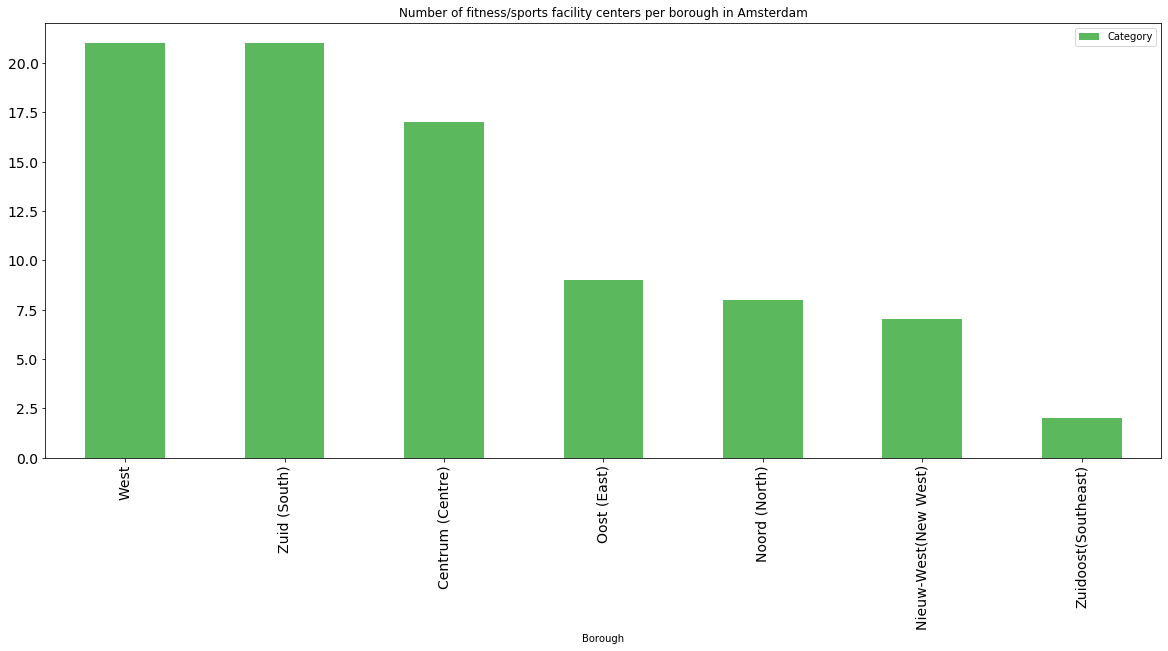

In [84]:
dfx = df_count_borough.drop(['Neighborhood','Venue'], axis=1)
ax = dfx.plot(kind='bar',
              figsize=(20,8),
              color=('#5cb85c'),
              width=0.5,
              fontsize=14)
ax.set_title('Number of fitness/sports facility centers per borough in Amsterdam')

As we can see, it looks like, Amsterdam west is the top choice in terms of facilities for people who are into sports or fitness in Amsterdam.
The next top boroughs are Amsterdam Centrum and Amsterdam Zuid.

### <font color='#4682B4'><b>2. How do you compare Amsterdam neighborhoods for someone with strong inclination for fitness or sport?</b></font>

### Get count of fitness or sport venues per neighborhood

In [85]:
df_count_neigh = df_venue_by_borough.groupby(['Neighborhood']).count()
df_count_neigh_coord = pd.merge(df_coord[['Neighborhood']], df_count_neigh, how='outer', on=['Neighborhood'])
df_count_neigh_coord.fillna(0, inplace=True)
print(df_count_neigh_coord.shape)
df_count_neigh_coord.set_index('Neighborhood', inplace=True)  
df_count_neigh_coord.sort_values(['Category'], ascending = False, axis = 0, inplace = True)
df_count_neigh_coord

(62, 4)


,Borough,Venue,Category
Neighborhood,,,
Vondelpark,8.0,8.0,8.0
Kinkerbuurt,7.0,7.0,7.0
Grachtengordel,4.0,4.0,4.0
Floradorp,4.0,4.0,4.0
Landlust,3.0,3.0,3.0
...,...,...,...
Oostzanerwerf,0.0,0.0,0.0
Nieuw Sloten,0.0,0.0,0.0
Geuzenveld,0.0,0.0,0.0


### Plot above data

Let's plot above conclusion into a bar graph to get a visual of the data

Text(0.5, 1.0, 'Number of fitness/sports facility centers per neighborhood in Amsterdam')

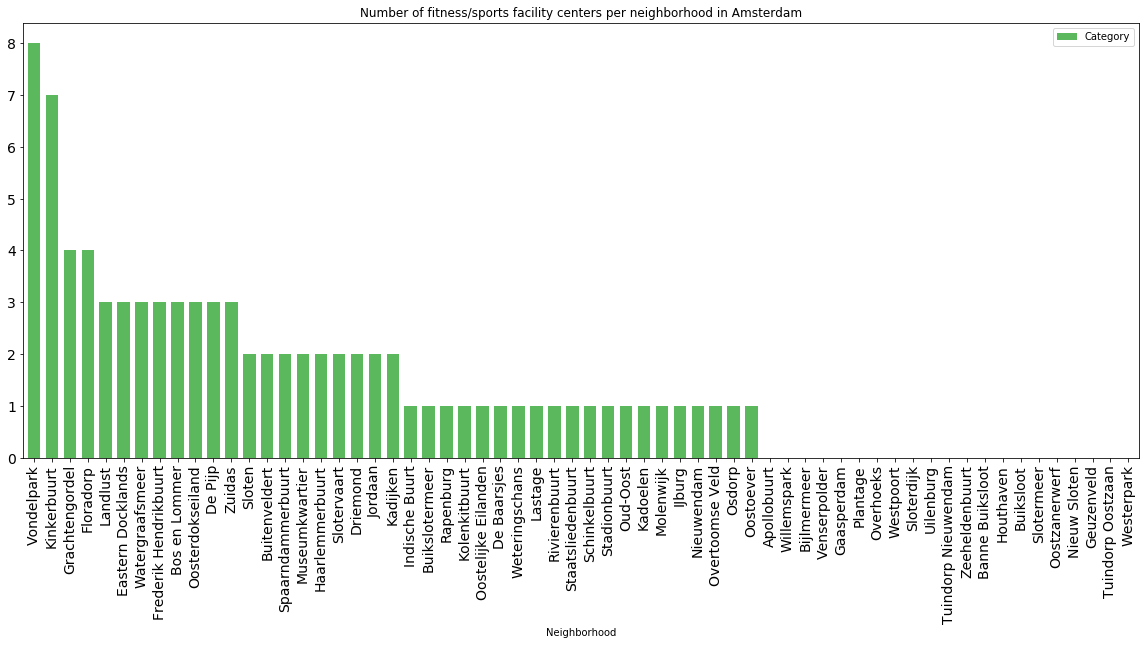

In [86]:
dfy = df_count_neigh_coord.drop(['Borough','Venue'], axis=1)
ax = dfy.plot(kind='bar',
              figsize=(20,8),
              color=('#5cb85c'),
              width=0.7,
              fontsize=14)
ax.set_title('Number of fitness/sports facility centers per neighborhood in Amsterdam')

As we can see from our analysis, 'Vondelpark' neighboorhood in Amsterdam seems to have the most number of fitness or sports centers/facilities/shops.
The second area that has most fitness/sports facilities is 'Kinkerbuurt'.

### <font color='#4682B4'><b>3. For someone looking to open a fitness studio or a sport facility, which are the areas they should look for?</b></font>

From the above graph, we see that there are certain areas to the right in the graph that do not seem to have any fitness/sports centers, facilities or shops in the area as per the results fetched by FourSquare API.

Let's get a list of these neighborhoods

In [87]:
df_zero_fitness = df_count_neigh_coord[df_count_neigh_coord.Category == 0.0]
df_zero_fitness.drop(['Borough','Venue'], axis=1, inplace = True)
df_zero_fitness.rename(columns={'Category':'Fitness/Sport Venues'}, inplace=True)
df_zero_fitness

C:\Users\Rahulika\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Rahulika\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Fitness/Sport Venues
Neighborhood,
Apollobuurt,0.0
Willemspark,0.0
Bijlmermeer,0.0
Venserpolder,0.0
Gaasperdam,0.0
Plantage,0.0
Overhoeks,0.0
Westpoort,0.0
Sloterdijk,0.0


These are the areas that are least suitable for sports/fitness enthusiasts.
These are also the areas best suited for someone looking for an area in Amsterdam to open a fitness or a sport center.

Above is the list of neighborhoods with best prospects for opening a fitness studio or a sport facility as per our analysis.

### <font color='#4682B4'><b>4. Which are the areas in Amsterdam with highest number of gyms?</b></font>

In [88]:
gym_venues = ['Gym / Fitness Center', 'Gym', 'Gym Pool', 'Gymnastics Gym']

In [89]:
df_venues_merged.head()

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Category
0,Grachtengordel,Centrum (Centre),52.370837,4.885478,525947cf11d2f0c57010cc1a,Marqt,52.370369,4.885127,Organic Grocery
1,Grachtengordel,Centrum (Centre),52.370837,4.885478,4b064d52f964a52086ea22e3,9 Straatjes,52.370251,4.885907,Shopping Mall
2,Grachtengordel,Centrum (Centre),52.370837,4.885478,4a27066bf964a520e18a1fe3,The Dylan,52.369273,4.884004,Hotel
3,Grachtengordel,Centrum (Centre),52.370837,4.885478,4a270656f964a520a98a1fe3,Hotel Estherea,52.370571,4.888292,Hotel
4,Grachtengordel,Centrum (Centre),52.370837,4.885478,4a27078ff964a5203c8e1fe3,Pulitzer's Bar,52.372553,4.884640,Hotel Bar


In [90]:
df_gyms = df_venues_merged[df_venues_merged['Category'].isin(gym_venues)]
print(df_gyms.shape)
df_gyms = df_gyms.reset_index()
df_gyms.drop(['index'], axis=1, inplace=True)
df_gyms.drop(['Neighborhood Latitude','Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
df_gyms.head()

(30, 9)


,Neighborhood,Borough,Venue Id,Venue,Category
0,Grachtengordel,Centrum (Centre),4b155b3cf964a5207cab23e3,Health Club Jordaan,Gym / Fitness Center
1,Grachtengordel,Centrum (Centre),4eb12a8ff5b931e2ae1f1dc8,BBB healthclub,Gym
2,Jordaan,Centrum (Centre),4b9bd396f964a5200c2a36e3,Sento Spa & Health,Gym
3,Kadijken,Centrum (Centre),4cd1c26a7b685481efe1c8f8,Oostenburg Sporthal,Gym / Fitness Center
4,Oosterdokseiland,Centrum (Centre),59a7e57c112c6c25cc1cccb2,Trainmore,Gym / Fitness Center


### Get count of gyms per borough

In [91]:
df_gyms_borough = df_gyms.groupby(['Borough']).count()
df_gyms_borough.sort_values(['Category'], ascending = False, axis = 0, inplace = True)
df_gyms_borough.drop(['Neighborhood','Venue'], axis=1, inplace = True)
df_gyms_borough.rename(columns={'Category':'Gym Count'}, inplace=True)
df_gyms_borough

,Venue Id,Gym Count
Borough,,
Zuid (South),9,9
Centrum (Centre),6,6
West,6,6
Oost (East),4,4
Noord (North),3,3
Nieuw-West(New West),2,2


As we see from the above data, of all boroughs in Amsterdam, Amsterdam West has the highest number of gyms (9)

### <font color='#4682B4'><b>5. What are the areas with highest number of yoga studios nearby?</b></font>

Let's limit our data to yoga related venues.

In [92]:
yoga_venues = ['Yoga Studio']

In [93]:
df_yoga = df_venues_merged[df_venues_merged['Category'].isin(yoga_venues)]
print(df_yoga.shape)
df_yoga = df_yoga.reset_index()
df_yoga.drop(['index'], axis=1, inplace=True)
df_yoga.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Id'], axis=1, inplace=True)
df_yoga.head()

(14, 9)


,Neighborhood,Borough,Venue,Venue Latitude,Venue Longitude,Category
0,Grachtengordel,Centrum (Centre),De Nieuwe Yogaschool,52.371581,4.878668,Yoga Studio
1,Grachtengordel,Centrum (Centre),Hot Flow Yoga,52.368909,4.881088,Yoga Studio
2,Haarlemmerbuurt,Centrum (Centre),Svaha Yoga,52.381002,4.882808,Yoga Studio
3,Haarlemmerbuurt,Centrum (Centre),Delight Yoga,52.385790,4.886139,Yoga Studio
4,Jordaan,Centrum (Centre),Equal Yoga,52.372486,4.877573,Yoga Studio


From the above data, we can infer that there are 16 yoga studios returned by our API in Amsterdam. Let's see how they're distributed by area.

In [94]:
df_yoga_borough = df_yoga.groupby(['Borough']).count()
df_yoga_borough.sort_values(['Category'], ascending = False, axis = 0, inplace = True)
df_yoga_borough.drop(['Neighborhood','Venue','Venue Latitude','Venue Longitude'], axis=1, inplace = True)
df_yoga_borough.rename(columns={'Category':'Yoga Studio Count'}, inplace=True)
df_yoga_borough

,Yoga Studio Count
Borough,
Centrum (Centre),7
West,5
Zuid (South),2


As we see from the above table, Amsterdam Centrum area has 7 yoga studios, followed by Amsterdam West with 5 yoga studios. Zuid area has 2 of them. The other areas, as per our results, do not seem to have venues marked 'Yoga Studios'

In [95]:
df_yoga['Neighborhood'].value_counts()

Kinkerbuurt              3
Grachtengordel           2
Haarlemmerbuurt          2
Jordaan                  1
De Pijp                  1
Spaarndammerbuurt        1
Kadijken                 1
Weteringschans           1
Vondelpark               1
Frederik Hendrikbuurt    1
Name: Neighborhood, dtype: int64

Looks like Kinkerbuurt neighborhood is best suited for yoga enthusiasts with 3 yoga studios followed by Grachtengordel, Haarlemmerbuurt with 2 yoga studios in the areas

### <font color='#4682B4'><b>6. What are the areas containing maximum number of health stores?</b></font>

Let's limit our data to venues containing health stores

In [96]:
health_store_venues = ['Organic Grocery', 'Health Food Store']

In [97]:
df_stores = df_venues_merged[df_venues_merged['Category'].isin(health_store_venues)]
print(df_stores.shape)
df_stores = df_stores.reset_index()
df_stores.drop(['index'], axis=1, inplace=True)
df_stores.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Id','Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
df_stores.head()

(8, 9)


,Neighborhood,Borough,Venue,Category
0,Grachtengordel,Centrum (Centre),Marqt,Organic Grocery
1,Haarlemmerbuurt,Centrum (Centre),Marqt,Organic Grocery
2,Haarlemmerbuurt,Centrum (Centre),STACH Food,Organic Grocery
3,Eastern Docklands,Oost (East),Marqt,Organic Grocery
4,Apollobuurt,Zuid (South),Vitamin store,Health Food Store


Our analysis has resulted with organic / health food stores. Let's see the frequency per borough

In [98]:
df_heatlh_store_borough = df_stores.groupby(['Borough']).count()
df_heatlh_store_borough.sort_values(['Category'], ascending = False, axis = 0, inplace = True)
df_heatlh_store_borough.drop(['Neighborhood','Venue'], axis=1, inplace = True)
df_heatlh_store_borough.rename(columns={'Category':'Health Stores Count'}, inplace=True)
df_heatlh_store_borough

,Health Stores Count
Borough,
Zuid (South),4
Centrum (Centre),3
Oost (East),1


We can see that Amsterdam Zuid area seems to have the highest number of health stores / organic stores as per our results

### <font color='#4682B4'><b>7. Which areas contain best rated gyms?</b></font>

Let's go back to our list of gyms with neighborhood and boroughs

In [99]:
print(df_gyms.shape)
df_gyms.head()

(30, 5)


,Neighborhood,Borough,Venue Id,Venue,Category
0,Grachtengordel,Centrum (Centre),4b155b3cf964a5207cab23e3,Health Club Jordaan,Gym / Fitness Center
1,Grachtengordel,Centrum (Centre),4eb12a8ff5b931e2ae1f1dc8,BBB healthclub,Gym
2,Jordaan,Centrum (Centre),4b9bd396f964a5200c2a36e3,Sento Spa & Health,Gym
3,Kadijken,Centrum (Centre),4cd1c26a7b685481efe1c8f8,Oostenburg Sporthal,Gym / Fitness Center
4,Oosterdokseiland,Centrum (Centre),59a7e57c112c6c25cc1cccb2,Trainmore,Gym / Fitness Center


By passing the Venue Id above to FourSquare API, let us get the number of likes per gym

Let us start with the first record in our list above (Venue Id: 4b155b3cf964a5207cab23e3)

In [100]:
venue_id = '4b155b3cf964a5207cab23e3'

url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(    
    venue_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)

results = requests.get(url).json()
likes = results['response']['likes']['count']
print('Venue {} has {} likes'.format(venue_id, likes))

Venue 4b155b3cf964a5207cab23e3 has 59 likes


Similar to above, now get the number of likes for all gyms in the list by calling Foursquare API to get likes, for each of the gyms

In [101]:
def getLikes(venue_ids):
    
    venue_likes=[]
    for venue_id in zip(venue_ids):
        venue_id = venue_id[0]
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(    
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        results = requests.get(url).json()
        l = results['response']['likes']['count']
        
        venue_likes.append([(venue_id, l)]);
        
    df_venue_likes = pd.DataFrame([item for venue_like in venue_likes for item in venue_like])
    df_venue_likes.columns = ['Venue Id','Likes']
    
    return(df_venue_likes)

In [102]:
gymVenueLikes = getLikes(venue_ids=df_gyms['Venue Id'])   
print(gymVenueLikes.shape)
gymVenueLikes.head()

(30, 2)


,Venue Id,Likes
0,4b155b3cf964a5207cab23e3,59
1,4eb12a8ff5b931e2ae1f1dc8,10
2,4b9bd396f964a5200c2a36e3,19
3,4cd1c26a7b685481efe1c8f8,7
4,59a7e57c112c6c25cc1cccb2,7


In [103]:
df_gyms_likes = pd.merge(df_gyms, gymVenueLikes, how='inner', on=['Venue Id'])
df_gyms_likes = df_gyms_likes.drop_duplicates()
df_gyms_likes = df_gyms_likes.reset_index()
df_gyms_likes.drop(['index'], axis=1, inplace=True)
print(df_gyms_likes.shape)
df_gyms_likes.head()

(30, 6)


,Neighborhood,Borough,Venue Id,Venue,Category,Likes
0,Grachtengordel,Centrum (Centre),4b155b3cf964a5207cab23e3,Health Club Jordaan,Gym / Fitness Center,59
1,Grachtengordel,Centrum (Centre),4eb12a8ff5b931e2ae1f1dc8,BBB healthclub,Gym,10
2,Jordaan,Centrum (Centre),4b9bd396f964a5200c2a36e3,Sento Spa & Health,Gym,19
3,Kadijken,Centrum (Centre),4cd1c26a7b685481efe1c8f8,Oostenburg Sporthal,Gym / Fitness Center,7
4,Oosterdokseiland,Centrum (Centre),59a7e57c112c6c25cc1cccb2,Trainmore,Gym / Fitness Center,7


Let's pick top 7 gyms by number of likes and remove any irrelevant columns

In [104]:
df_top_gyms = df_gyms_likes
df_top_gyms.sort_values(['Likes'], ascending = False, axis = 0, inplace = True)
df_top_gyms.drop(['Neighborhood','Venue Id'], axis=1, inplace=True)
df_top_gyms = df_gyms_likes.reset_index()
df_top_gyms.drop(['index'], axis=1, inplace=True)
df_top_gyms.head(7)

,Borough,Venue,Category,Likes
0,Centrum (Centre),Health Club Jordaan,Gym / Fitness Center,59
1,Zuid (South),Clubsportive,Gym,46
2,West,Shape-all-in,Gym / Fitness Center,26
3,Zuid (South),Fresh Fitness,Gym,24
4,Centrum (Centre),Kensho Premium Fitness,Gym / Fitness Center,21
5,Nieuw-West(New West),Palestra Wellnessclub,Gym,20
6,Centrum (Centre),Sento Spa & Health,Gym,19


Above are the top rated gyms in Amsterdam. The most popular gym, 'Health Club Jordaan' is in Centrum area, followed by 'Clubsportive' in Zuid area.
We can see that Centrum has 3 of the 7 top gyms.